In [1]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 

In [2]:
input_size = 784 # 28x28
hidden_sizes = [500,300] 
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001 

In [3]:
# Import MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=True, 
                                   transform=transforms.ToTensor(),  
                                       download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                       train=False, 
                                       transform=transforms.ToTensor()) 

In [4]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                       batch_size=batch_size, 
                                       shuffle=False) 

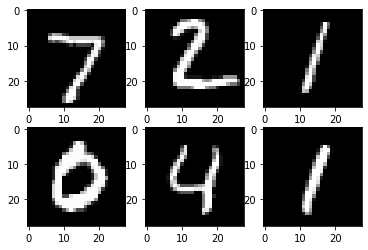

In [5]:
examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show() 

In [17]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        Ns = [*hidden_sizes]
        Ns.insert(0,input_size)
        hidden_layers = []
        for i in range(len(Ns) - 1):
            hidden_layers.append(nn.Linear(Ns[i], Ns[i + 1]))
            hidden_layers.append(nn.ReLU())
        self.layers = nn.Sequential(*hidden_layers)

        self.l2 = nn.Linear(Ns[-1], num_classes)   
    def forward(self, x):
        out = self.layers(x)
        out = self.l2(out)
        return out 

In [7]:
device='cpu'
model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)
import copy
model_i = copy.deepcopy(model)



In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 


In [9]:
n_total_steps = len(train_loader)
model_t_list = [model_i]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1)%20 == 0:
            model_t_list.append(copy.deepcopy(model))
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}') 

/home/omri/anaconda3/envs/mc_docker/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch [1/5], Step[100/600], Loss: 0.5035
Epoch [1/5], Step[200/600], Loss: 0.3764
Epoch [1/5], Step[300/600], Loss: 0.2464
Epoch [1/5], Step[400/600], Loss: 0.1450
Epoch [1/5], Step[500/600], Loss: 0.1893
Epoch [1/5], Step[600/600], Loss: 0.2311
Epoch [2/5], Step[100/600], Loss: 0.0959
Epoch [2/5], Step[200/600], Loss: 0.0693
Epoch [2/5], Step[300/600], Loss: 0.1453
Epoch [2/5], Step[400/600], Loss: 0.2012
Epoch [2/5], Step[500/600], Loss: 0.0913
Epoch [2/5], Step[600/600], Loss: 0.0338
Epoch [3/5], Step[100/600], Loss: 0.0551
Epoch [3/5], Step[200/600], Loss: 0.0283
Epoch [3/5], Step[300/600], Loss: 0.0242
Epoch [3/5], Step[400/600], Loss: 0.0421
Epoch [3/5], Step[500/600], Loss: 0.0458
Epoch [3/5], Step[600/600], Loss: 0.0774
Epoch [4/5], Step[100/600], Loss: 0.0459
Epoch [4/5], Step[200/600], Loss: 0.0030
Epoch [4/5], Step[300/600], Loss: 0.0155
Epoch [4/5], Step[400/600], Loss: 0.0688
Epoch [4/5], Step[500/600], Loss: 0.0411
Epoch [4/5], Step[600/600], Loss: 0.0441
Epoch [5/5], Ste

In [10]:
model_f = copy.deepcopy(model)
model_t_list.append(model_f)

In [11]:
def evaluate_model_loss(model, data_loader):
    with torch.no_grad():
        loss = 0
        n_iters = 0
        for images, labels in data_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            curr_loss = criterion(outputs, labels).item()
            loss+=curr_loss*images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            n_iters += 1
        loss = loss/len(data_loader.sampler)
#         print(f'Loss of the network: {loss} ') 
    return loss
# loss = evaluate_model_loss(model, train_loader)

### Linear interploate between initialized and converged models

In [13]:
import numpy as np
def linear_interpolation(model_i,model_f,alpha,data_loader):
    curr_model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)
    state_dict = curr_model.state_dict()
    i_state_dict = model_i.state_dict()
    f_state_dict = model_f.state_dict()
    for (_,i_param),(_,f_param),(name,param) in zip(i_state_dict.items(), f_state_dict.items(), state_dict.items()):
        state_dict[name].copy_((1-alpha)*i_param+alpha*f_param)
    train_loss = evaluate_model_loss(curr_model, data_loader)
    return train_loss

x=[]
y_train=[]
y_test=[]
for i in np.linspace(0,2,10):
    x.append(i)
    y_train.append(linear_interpolation(model_i,model_f,i,train_loader))
    y_test.append(linear_interpolation(model_i,model_f,i,test_loader))

Text(0.5, 1.0, 'Linear interpolation of ReLU on MNIST')

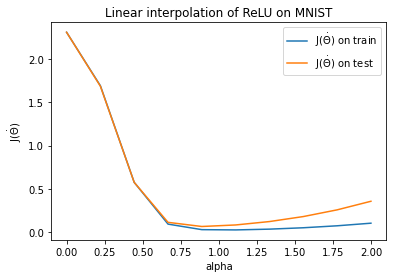

In [15]:
import pylab
pylab.plot(x, y_train, label="J($\dot{\Theta}$) on train")
pylab.plot(x, y_test, label="J($\dot{\Theta}$) on test")
pylab.legend()
pylab.xlabel('alpha')
pylab.ylabel(r"J($\dot{\Theta}$)")
pylab.title('Linear interpolation of ReLU on MNIST')

### How far is SGD from this monotonic decreasing path from init to final?

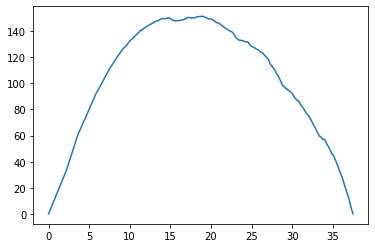

In [16]:
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector

def compute_u(model_i, model_f):
    i_params = parameters_to_vector(model_i.parameters())
    f_params = parameters_to_vector(model_f.parameters())
    minus_params = f_params-i_params
    return F.normalize(minus_params,dim=0)
    
def alpha_beta(model_t,u, model_i):
    i_params = parameters_to_vector(model_i.parameters())
    t_params = parameters_to_vector(model_t.parameters())
    
    alpha = torch.dot((t_params-i_params),u)
    v = t_params-(i_params+alpha*u)
    v_normalized = F.normalize(v,dim=0)
    beta = torch.dot(v,v)
    return alpha, beta

u = compute_u(model_i,model_f)
alpha_list = []
beta_list = []
for model_t in model_t_list:
    alpha, beta = alpha_beta(model_t, u, model_i)
    alpha_list.append(alpha)
    beta_list.append(beta)

pylab.plot(alpha_list, beta_list)
    